In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")


In [2]:
stockName='TSM'

In [3]:
tweetFile=pd.read_csv(r"C:\Users\dnyap\OneDrive\Desktop\TOC Project\stock_tweets.csv")

In [4]:
tweetFile.shape

(80793, 4)

In [5]:
tweetFile['Stock Name'].unique()

array(['TSLA', 'MSFT', 'PG', 'META', 'AMZN', 'GOOG', 'AMD', 'AAPL',
       'NFLX', 'TSM', 'KO', 'F', 'COST', 'DIS', 'VZ', 'CRM', 'INTC', 'BA',
       'BX', 'NOC', 'PYPL', 'ENPH', 'NIO', 'ZS', 'XPEV'], dtype=object)

In [6]:
tweetFile.head(5)

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [7]:
dataframe=tweetFile[tweetFile['Stock Name']==stockName]
print(dataframe.shape)
dataframe.head()

(11034, 4)


,Date,Tweet,Stock Name,Company Name
62741,2022-09-29 22:23:02+00:00,EG vs FNC is a deadly matchup.\n\nEG using the...,TSM,Taiwan Semiconductor Manufacturing Company Lim...
62742,2022-09-29 21:50:16+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...
62743,2022-09-29 21:13:20+00:00,I keep looking at the current #R6NAL standings...,TSM,Taiwan Semiconductor Manufacturing Company Lim...
62744,2022-09-29 19:35:26+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...
62745,2022-09-29 19:19:05+00:00,@joe1chief @BTSsmash @coinbase @Panda_Plup @Li...,TSM,Taiwan Semiconductor Manufacturing Company Lim...


In [8]:
sentiment_df=dataframe.copy()
sentiment_df["Sentiment_Score"]=''
sentiment_df["Negative"]=''
sentiment_df["Neutral"]=''
sentiment_df["Positive"]=''
sentiment_df.head()

,Date,Tweet,Stock Name,Company Name,Sentiment_Score,Negative,Neutral,Positive
62741,2022-09-29 22:23:02+00:00,EG vs FNC is a deadly matchup.\n\nEG using the...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,,,,
62742,2022-09-29 21:50:16+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,,,,
62743,2022-09-29 21:13:20+00:00,I keep looking at the current #R6NAL standings...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,,,,
62744,2022-09-29 19:35:26+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,,,,
62745,2022-09-29 19:19:05+00:00,@joe1chief @BTSsmash @coinbase @Panda_Plup @Li...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,,,,


In [9]:
%%time
SentimentAnalyzer=SentimentIntensityAnalyzer()
for index,row in sentiment_df.T.iteritems():
    sentence=unicodedata.normalize('NFKD',sentiment_df.loc[index,'Tweet'])
    sentence_sentiment=SentimentAnalyzer.polarity_scores(sentence)
    sentiment_df.at[index,'Sentiment_Score']=sentence_sentiment['compound']
    sentiment_df.at[index,'Negative']=sentence_sentiment['neg']
    sentiment_df.at[index,'Neutral']=sentence_sentiment['neu']
    sentiment_df.at[index,'Positive']=sentence_sentiment['pos']
      

CPU times: total: 2.36 s
Wall time: 2.96 s


In [10]:
sentiment_df.head()

,Date,Tweet,Stock Name,Company Name,Sentiment_Score,Negative,Neutral,Positive
62741,2022-09-29 22:23:02+00:00,EG vs FNC is a deadly matchup.\n\nEG using the...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,-0.4215,0.093,0.907,0.0
62742,2022-09-29 21:50:16+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,0.0,0.0,1.0,0.0
62743,2022-09-29 21:13:20+00:00,I keep looking at the current #R6NAL standings...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,0.4404,0.0,0.929,0.071
62744,2022-09-29 19:35:26+00:00,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,0.3182,0.0,0.839,0.161
62745,2022-09-29 19:19:05+00:00,@joe1chief @BTSsmash @coinbase @Panda_Plup @Li...,TSM,Taiwan Semiconductor Manufacturing Company Lim...,-0.4404,0.127,0.873,0.0


In [11]:
sentiment_df['Date']=pd.to_datetime(sentiment_df['Date'])
sentiment_df['Date']=sentiment_df['Date'].dt.date
sentiment_df=sentiment_df.drop(columns=['Negative','Positive','Neutral','Stock Name','Company Name'])

In [12]:
sentiment_df.head()

,Date,Tweet,Sentiment_Score
62741,2022-09-29,EG vs FNC is a deadly matchup.\n\nEG using the...,-0.4215
62742,2022-09-29,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,0.0
62743,2022-09-29,I keep looking at the current #R6NAL standings...,0.4404
62744,2022-09-29,@BTSsmash @coinbase @Panda_Plup @LiquidHbox @T...,0.3182
62745,2022-09-29,@joe1chief @BTSsmash @coinbase @Panda_Plup @Li...,-0.4404


In [13]:
twitter_data=sentiment_df.groupby([sentiment_df['Date']]).mean()
twitter_data.shape

(365, 1)

In [14]:
twitter_data.head()

,Sentiment_Score
Date,
2021-09-30,0.383726
2021-10-01,0.230249
2021-10-02,0.240483
2021-10-03,0.244017
2021-10-04,0.061684


# Dataset for training

In [15]:
stocks_data=pd.read_csv(r'C:\Users\dnyap\OneDrive\Desktop\TOC Project\stock_yfinance_data.csv')
print(stocks_data.shape)
stocks_data.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [16]:
stdf=stocks_data[stocks_data['Stock Name']==stockName]
stdf['Date']=pd.to_datetime(stdf['Date'])
stdf['Date']=stdf['Date'].dt.date

In [17]:
final=stdf.join(twitter_data,how="left",on="Date")
final=final.drop(columns=['Stock Name'])
print(final.shape)

(252, 8)


In [18]:
final.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment_Score
2268,2021-09-30,112.430000,113.349998,111.650002,111.650002,109.457535,6433400,0.383726
2269,2021-10-01,112.000000,112.300003,110.300003,111.559998,109.369293,5315200,0.230249
2270,2021-10-04,111.000000,111.430000,108.519997,109.019997,106.879173,8514500,0.061684
2271,2021-10-05,109.800003,110.349998,109.220001,109.260002,107.114464,8039600,0.149810
2272,2021-10-06,108.440002,109.519997,107.580002,109.339996,107.192886,7553600,0.212018


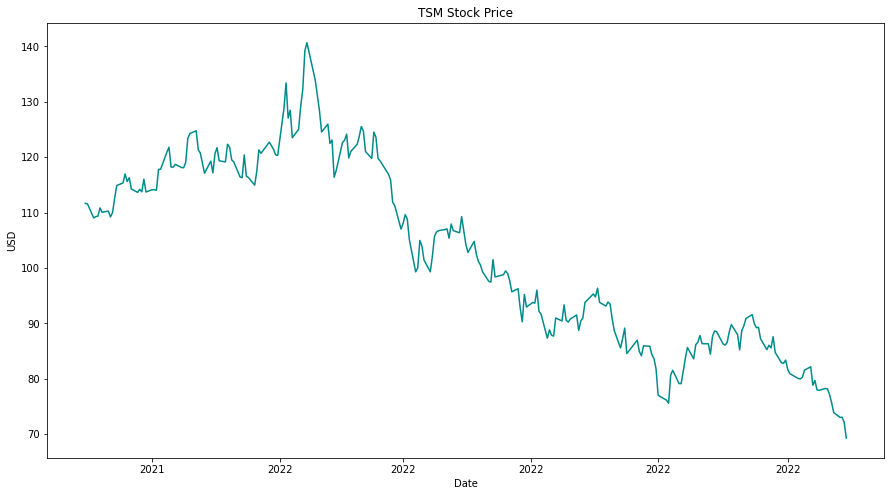

In [19]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(final['Date'], final['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stockName} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [20]:
def technical_ind(dt):
    dt['MA10'] = dt.iloc[:,4].rolling(window=10).mean() #Close column
    dt['MA30'] = dt.iloc[:,4].rolling(window=30).mean() #Close Column

    dt['MACD'] = dt.iloc[:,4].ewm(span=26).mean() - dt.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    dt['30SD'] = dt.iloc[:, 4].rolling(30).std()
    dt['upper_band'] = dt['MA30'] + (dt['30SD'] * 2)
    dt['lower_band'] = dt['MA30'] - (dt['30SD'] * 2)

    # Create Exponential moving average
    dt['EMA'] = dt.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    dt['logmomentum'] = np.log(dt.iloc[:,4] - 1)

    return dt

In [21]:
tech_ind = technical_ind(final)
dataset = tech_ind.iloc[30:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment_Score,MA10,MA30,MACD,30SD,upper_band,lower_band,EMA,logmomentum
0,2021-11-11,119.260002,120.470001,117.800003,118.190002,115.869102,6994000,0.035217,117.061001,114.117000,-1.107582,3.480480,121.077960,107.156040,118.515321,4.763797
1,2021-11-12,118.389999,118.820000,117.269997,118.690002,116.359291,6947200,-0.048463,117.560001,114.354667,-1.096408,3.542734,121.440136,107.269198,118.631775,4.768054
2,2021-11-15,119.320000,119.639999,117.510002,118.120003,115.800484,5157000,0.156317,117.960001,114.658000,-1.260675,3.458806,121.575612,107.740389,118.290594,4.763199
3,2021-11-16,117.690002,118.379997,117.160004,118.080002,115.761261,5555100,0.219073,118.357001,114.952000,-1.141112,3.357520,121.667041,108.236959,118.150199,4.762857
4,2021-11-17,118.000000,119.550003,117.510002,119.059998,116.722015,6391400,0.213920,118.862001,115.276000,-0.999813,3.265003,121.806007,108.745994,118.756731,4.771193


In [22]:
def technical_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA10'], label='Moving Average (10 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA30'], label='Moving Average (30 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

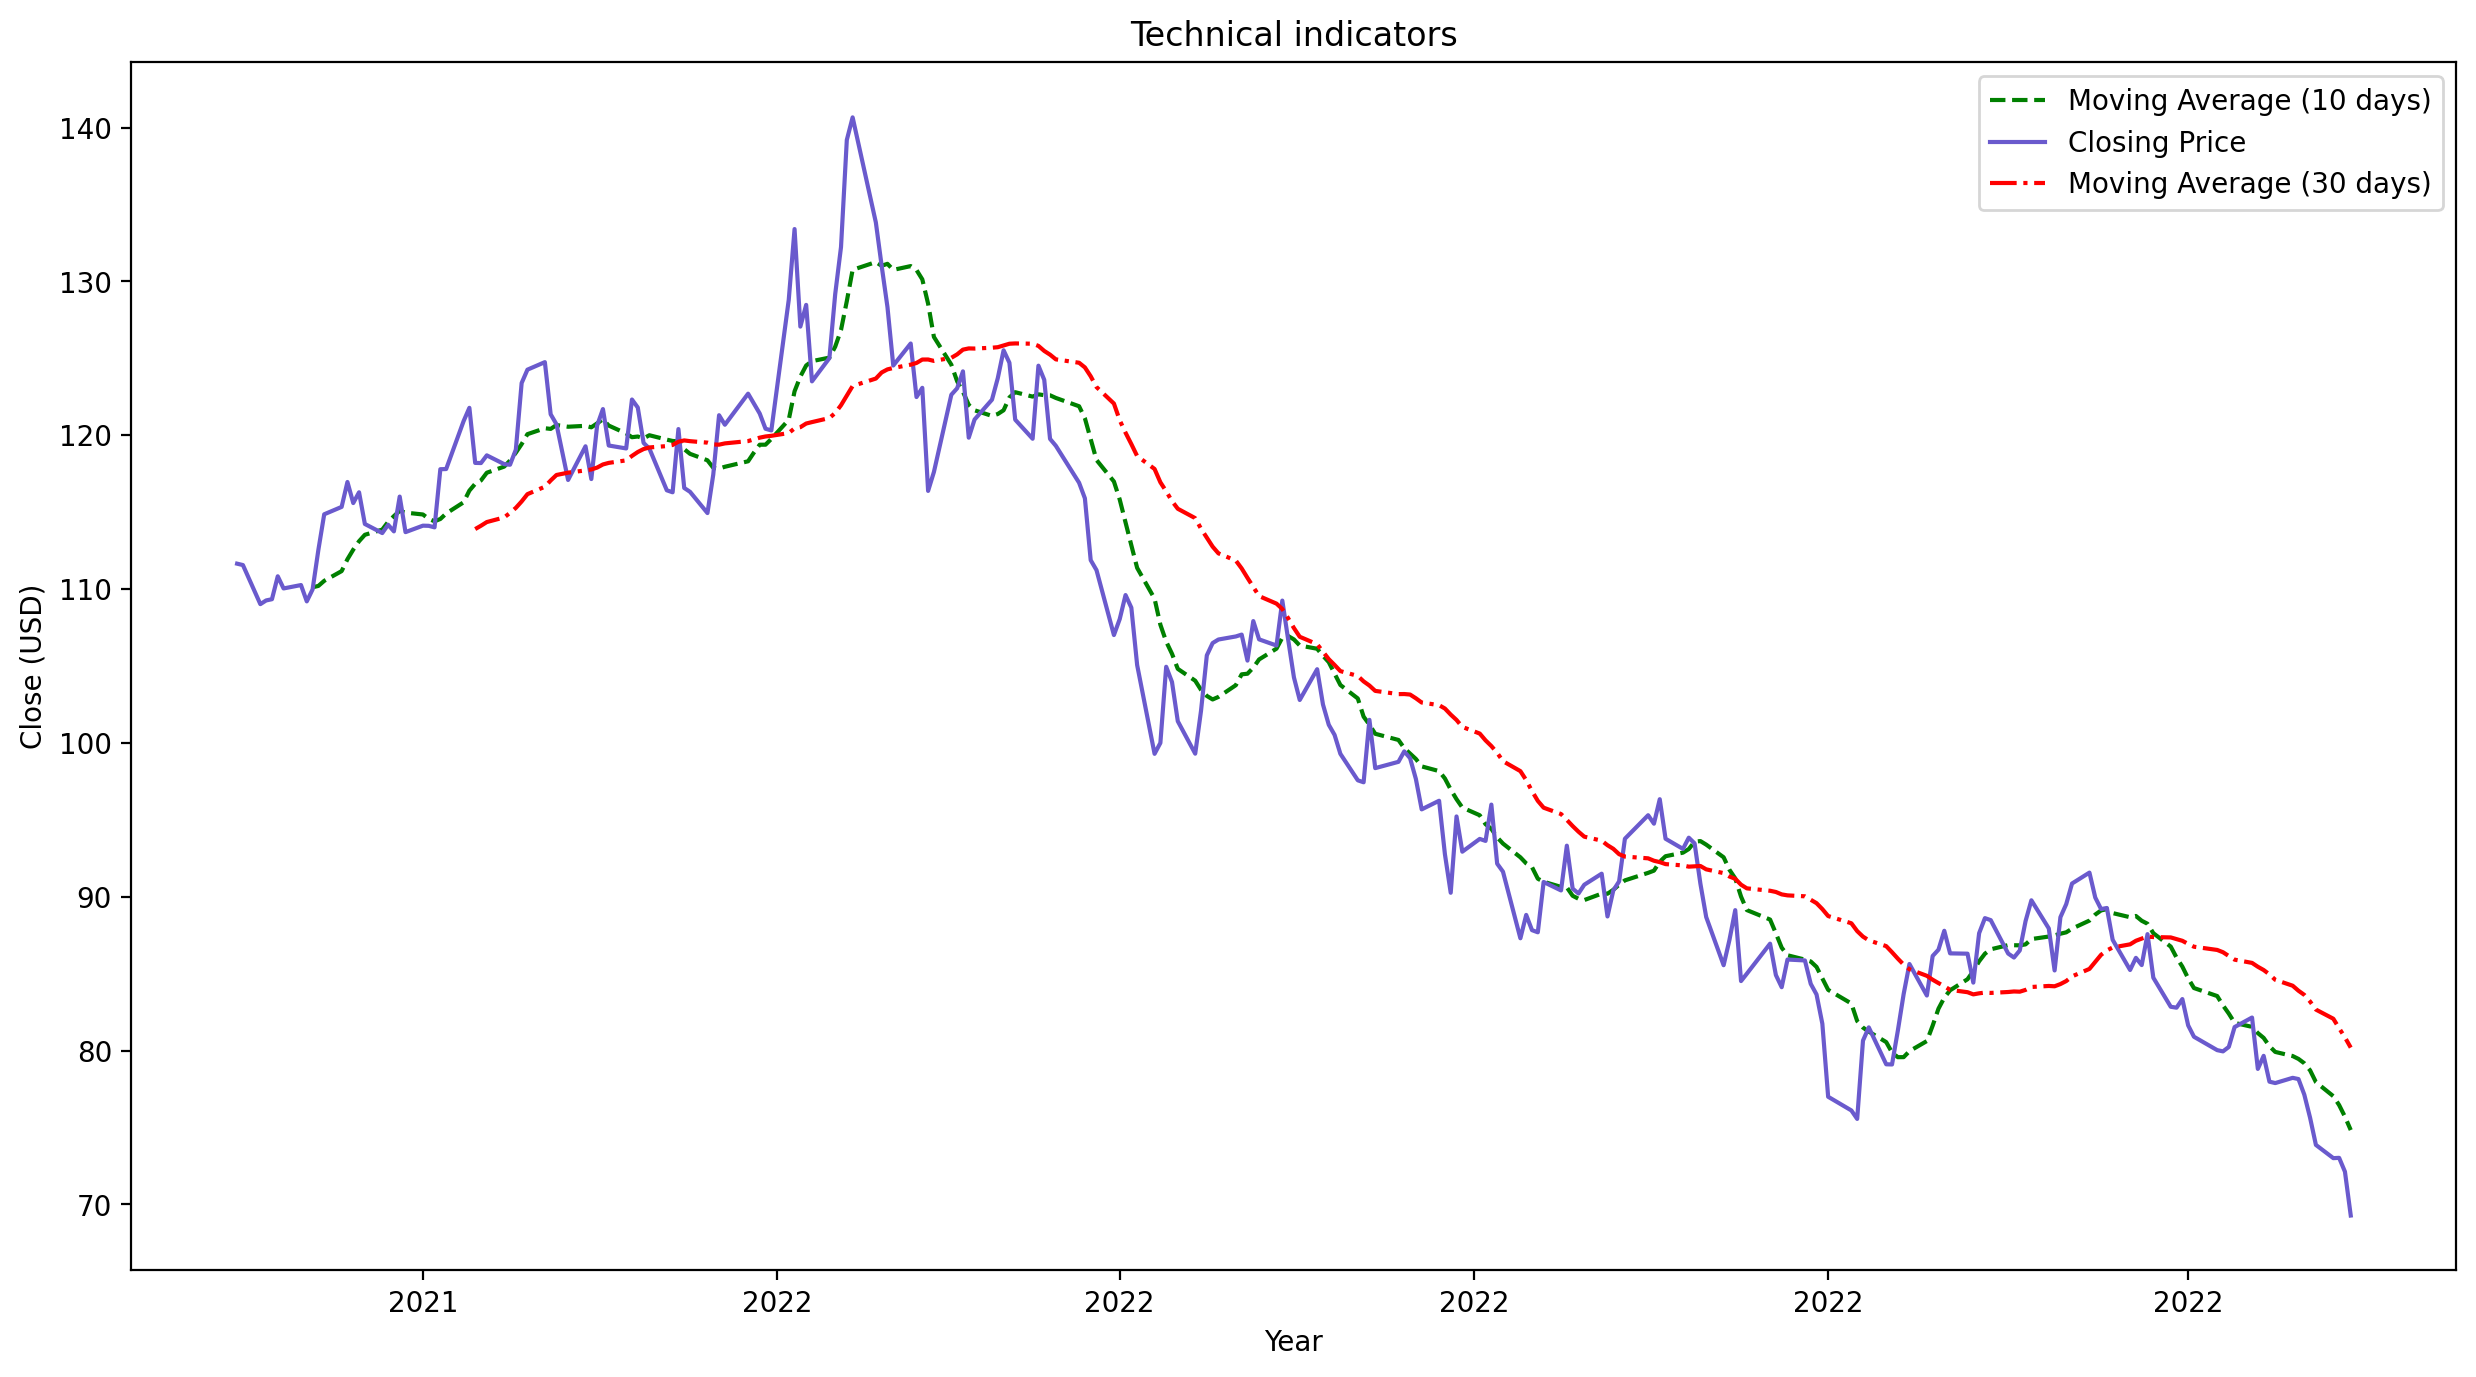

In [23]:
technical_ind(tech_ind)

In [24]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [25]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [26]:
def normalize_data(df, range, target_column):

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [27]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [28]:
def train_test_split(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [29]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index


In [30]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = train_test_split(X_batched)
y_train, y_test, = train_test_split(y_batched)
yc_train, yc_test, = train_test_split(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (217, 5, 15)
y shape: (217, 1)
yc shape: (217, 5, 1)


In [31]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

# Building Generative Adversarial Network Model

In [32]:
def generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [33]:
def discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [34]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [35]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}


In [36]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stockName}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stockName}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)
 

In [37]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [38]:
@tf.function 

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [39]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stockName}", fontsize=20)
    plt.show()
learning_rate = 5e-4
epochs = 500

In [40]:
g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = discriminator_model(X_train.shape[1])

In [41]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [42]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


 10%|███████▉                                                                         | 49/500 [00:53<05:06,  1.47it/s]

 10%|████████                                                                         | 50/500 [00:54<05:17,  1.42it/s]

epoch 50 discriminator_loss 1.338407 generator_loss 0.7409657


 20%|████████████████                                                                 | 99/500 [01:26<04:26,  1.51it/s]

 20%|████████████████                                                                | 100/500 [01:27<04:35,  1.45it/s]

epoch 100 discriminator_loss 1.3359549 generator_loss 0.6652185


 30%|███████████████████████▊                                                        | 149/500 [02:00<03:54,  1.50it/s]

 30%|████████████████████████                                                        | 150/500 [02:01<04:01,  1.45it/s]

epoch 150 discriminator_loss 1.3702956 generator_loss 0.696474


 40%|███████████████████████████████▊                                                | 199/500 [02:33<03:20,  1.50it/s]

 40%|████████████████████████████████                                                | 200/500 [02:34<03:26,  1.45it/s]

epoch 200 discriminator_loss 1.3908706 generator_loss 0.70025223


 50%|███████████████████████████████████████▊                                        | 249/500 [03:07<02:47,  1.50it/s]

 50%|████████████████████████████████████████                                        | 250/500 [03:07<02:51,  1.46it/s]

epoch 250 discriminator_loss 1.3873739 generator_loss 0.6654922


 60%|███████████████████████████████████████████████▊                                | 299/500 [03:40<02:14,  1.49it/s]

 60%|████████████████████████████████████████████████                                | 300/500 [03:41<02:19,  1.44it/s]

epoch 300 discriminator_loss 1.3873131 generator_loss 0.6997565


 70%|███████████████████████████████████████████████████████▊                        | 349/500 [04:14<01:40,  1.50it/s]

 70%|████████████████████████████████████████████████████████                        | 350/500 [04:14<01:43,  1.44it/s]

epoch 350 discriminator_loss 1.38459 generator_loss 0.6830304


 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [04:47<01:07,  1.49it/s]

 80%|████████████████████████████████████████████████████████████████                | 400/500 [04:48<01:09,  1.44it/s]

epoch 400 discriminator_loss 1.3879011 generator_loss 0.6982019


 90%|███████████████████████████████████████████████████████████████████████▊        | 449/500 [05:21<00:34,  1.49it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [05:22<00:34,  1.45it/s]

epoch 450 discriminator_loss 1.386513 generator_loss 0.6929684


100%|███████████████████████████████████████████████████████████████████████████████▊| 499/500 [05:55<00:00,  1.48it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:56<00:00,  1.40it/s]

epoch 500 discriminator_loss 1.3860881 generator_loss 0.68093234


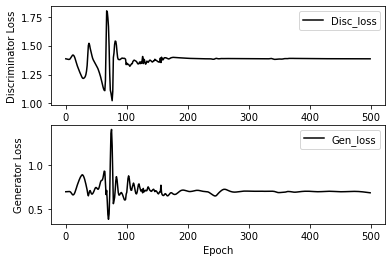

In [43]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [44]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stockName}/generator_V_{epochs-1}.h5')

Test RMSE:  2.540395210405786


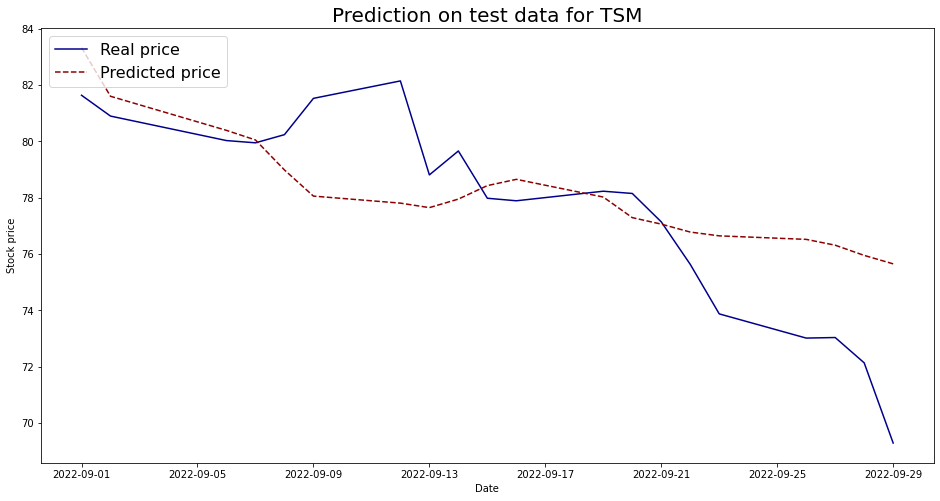

In [45]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)